<a href="https://colab.research.google.com/github/rlskoeser/shxco-missingdata-specreading/blob/main/missing-data/Sco_missing_borrowing_activity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Missing Borrowing Activity Data from Shakespeare and Company Project

This notebook explores and predicts missing data related to borrowing. It contains the code for figures 7 and 8 in our paper.

## Setup Libraries and Load S&Co Data

In [1]:
import pandas as pd

In [3]:
# use v1.2 datasets; load from our repo for convenience
csv_urls = {
    'members': 'https://raw.githubusercontent.com/ZoeLeBlanc/unknown_borrowers/main/dataset_generator/source_data/SCoData_members_v1.2_2022-01.csv',
    'books': 'https://raw.githubusercontent.com/ZoeLeBlanc/unknown_borrowers/main/dataset_generator/source_data/SCoData_books_v1.2_2022-01.csv',
    'events': 'https://raw.githubusercontent.com/ZoeLeBlanc/unknown_borrowers/main/dataset_generator/source_data/SCoData_events_v1.2_2022-01.csv',
    # project-specific data
    'partial_borrowers': 'https://github.com/ZoeLeBlanc/unknown_borrowers/raw/main/dataset_generator/data/partial_borrowers_collapsed.csv',
    'borrow_overrides': 'https://raw.githubusercontent.com/ZoeLeBlanc/unknown_borrowers/main/dataset_generator/data/long_borrow_overrides.csv'
}

# load events
events_df = pd.read_csv(csv_urls['events'])

# split multiple members for shared accounts in events
events_df[
    ["first_member_uri", "second_member_uri"]
] = events_df.member_uris.str.split(";", expand=True)

# working with the first member for now...
# generate short ids equivalent to those in member and book dataframes
events_df["member_id"] = events_df.first_member_uri.apply(
    lambda x: x.split("/")[-2]
)
events_df["item_id"] = events_df.item_uri.apply(
    lambda x: x.split("/")[-2] if pd.notna(x) else None
)

## identify borrows and subscriptions

In [6]:
# subset data for only those with complete start and end dates
 
# NOTE: do we really need to exclude borrow events with no end date?

date_events = events_df[(events_df.start_date.str.len() > 9) & (events_df.end_date.str.len() > 9)].copy()
# turn start/end dates into datetimes
date_events['start_datetime'] = pd.to_datetime(date_events.start_date, format='%Y-%m-%d', errors='ignore')
date_events['end_datetime'] = pd.to_datetime(date_events.end_date, format='%Y-%m-%d', errors='ignore')
date_events = date_events.sort_values(by=['start_datetime'])
date_events.head()

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,...,source_type,source_citation,source_manifest,source_image,first_member_uri,second_member_uri,member_id,item_id,start_datetime,end_datetime
671,Subscription,1919-11-17,1919-12-17,https://shakespeareandco.princeton.edu/members...,Claude Cahun / Mlle Lucie Schwob,"Cahun, Claude",4.0,NaN,1 month,30.0,...,Lending Library Card;Logbook,"Sylvia Beach, Lucie Schwob Lending Library Car...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/3a...,https://shakespeareandco.princeton.edu/members...,None,cahun,None,1919-11-17,1919-12-17
29915,Subscription,1919-11-17,1920-11-17,https://shakespeareandco.princeton.edu/members...,Marcelle Flot,"Flot, Marcelle",28.0,NaN,1 year,366.0,...,Logbook,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,https://shakespeareandco.princeton.edu/members...,None,flot-marcelle,None,1919-11-17,1920-11-17
29914,Subscription,1919-11-17,1920-02-17,https://shakespeareandco.princeton.edu/members...,Mrs. Worthing,"Worthing, Mrs.",12.0,NaN,3 months,92.0,...,Logbook,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,https://shakespeareandco.princeton.edu/members...,None,worthing,None,1919-11-17,1920-02-17
674,Borrow,1919-11-18,1919-11-28,https://shakespeareandco.princeton.edu/members...,Denise Ulmann,"Ulmann, Denise",NaN,NaN,NaN,NaN,...,Lending Library Card,"Sylvia Beach, Mlle Denise Ulmann Lending Libra...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/86...,https://shakespeareandco.princeton.edu/members...,None,ulmann,wilde-profundis,1919-11-18,1919-11-28
29916,Subscription,1919-11-18,1920-05-18,https://shakespeareandco.princeton.edu/members...,Anne Evans,"Evans, Anne",35.0,14.0,6 months,182.0,...,Logbook,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,https://shakespeareandco.princeton.edu/members...,None,evans-anne,None,1919-11-18,1920-05-18


In [7]:
# borrow events 
borrow_events = date_events[date_events.event_type == 'Borrow']

# subset data for subscription events with complete dates
subscription_events = date_events[date_events.event_type.isin(['Subscription', 'Renewal', 'Supplement'])].copy()

In [8]:
# some subscriptions (~377) do not have subscription volume documented;
# subscription volume is 1 at minumim
subscription_events["subscription_volumes"] = subscription_events.subscription_volumes.apply(lambda x: x if pd.notna(x) else 1)

In [9]:
# date range for subscriptions
earliest_date = date_events.start_datetime.iloc[0]
# end date for the last subscription
subs_end_date = subscription_events.end_datetime.max()

In [10]:
# load members
members_df = pd.read_csv(csv_urls['members'])

# for now, use has card to identify borrows that belong to subscriptions (but this is approximate)
member_subs = subscription_events.copy()
member_subs[['first_member_uri','second_member_uri']] = member_subs.member_uris.str.split(';', expand=True)
# handle multiple member uris (joint accounts) in subscriptions by merging on the first one (has card should be same)
member_subs = pd.merge(left=member_subs, right=members_df, left_on="first_member_uri", right_on="uri")
member_subs = member_subs[member_subs.has_card]


## identify subscriptions with borrows

In [11]:
# make a copy of the dataframe so pandas won't complain about setting values on a slice
subscriptions_df = subscription_events.copy()

def borrows_within_sub(subscription):
  # identify and count any borrow events that *start* during this subscription
  # (do we want start or any overlap? start matters more when estimating book events)
  return len(borrow_events[(borrow_events.member_id == subscription.member_id) & 
              (subscription.start_date <= borrow_events.start_date) & (borrow_events.start_date <= subscription.end_date)])

subscriptions_df['documented_borrows'] = subscriptions_df.apply(borrows_within_sub, axis=1)
subscriptions_df.head()

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,...,source_citation,source_manifest,source_image,first_member_uri,second_member_uri,member_id,item_id,start_datetime,end_datetime,documented_borrows
671,Subscription,1919-11-17,1919-12-17,https://shakespeareandco.princeton.edu/members...,Claude Cahun / Mlle Lucie Schwob,"Cahun, Claude",4.0,NaN,1 month,30.0,...,"Sylvia Beach, Lucie Schwob Lending Library Car...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/3a...,https://shakespeareandco.princeton.edu/members...,None,cahun,None,1919-11-17,1919-12-17,3
29915,Subscription,1919-11-17,1920-11-17,https://shakespeareandco.princeton.edu/members...,Marcelle Flot,"Flot, Marcelle",28.0,NaN,1 year,366.0,...,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,https://shakespeareandco.princeton.edu/members...,None,flot-marcelle,None,1919-11-17,1920-11-17,0
29914,Subscription,1919-11-17,1920-02-17,https://shakespeareandco.princeton.edu/members...,Mrs. Worthing,"Worthing, Mrs.",12.0,NaN,3 months,92.0,...,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,https://shakespeareandco.princeton.edu/members...,None,worthing,None,1919-11-17,1920-02-17,0
29916,Subscription,1919-11-18,1920-05-18,https://shakespeareandco.princeton.edu/members...,Anne Evans,"Evans, Anne",35.0,14.0,6 months,182.0,...,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,https://shakespeareandco.princeton.edu/members...,None,evans-anne,None,1919-11-18,1920-05-18,0
672,Subscription,1919-11-18,1919-12-18,https://shakespeareandco.princeton.edu/members...,Henri Regnier,"Regnier, Henri",4.0,5.6,1 month,30.0,...,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",;https://figgy.princeton.edu/concern/scanned_r...,;https://iiif.princeton.edu/loris/figgy_prod/c...,https://shakespeareandco.princeton.edu/members...,None,regnier,None,1919-11-18,1919-12-18,1


In [12]:
# check — example subscriptions with no borrows
subscriptions_df[subscriptions_df.documented_borrows == 0].head()

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,...,source_citation,source_manifest,source_image,first_member_uri,second_member_uri,member_id,item_id,start_datetime,end_datetime,documented_borrows
29915,Subscription,1919-11-17,1920-11-17,https://shakespeareandco.princeton.edu/members...,Marcelle Flot,"Flot, Marcelle",28.0,NaN,1 year,366.0,...,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,https://shakespeareandco.princeton.edu/members...,None,flot-marcelle,None,1919-11-17,1920-11-17,0
29914,Subscription,1919-11-17,1920-02-17,https://shakespeareandco.princeton.edu/members...,Mrs. Worthing,"Worthing, Mrs.",12.0,NaN,3 months,92.0,...,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,https://shakespeareandco.princeton.edu/members...,None,worthing,None,1919-11-17,1920-02-17,0
29916,Subscription,1919-11-18,1920-05-18,https://shakespeareandco.princeton.edu/members...,Anne Evans,"Evans, Anne",35.0,14.0,6 months,182.0,...,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,https://shakespeareandco.princeton.edu/members...,None,evans-anne,None,1919-11-18,1920-05-18,0
677,Subscription,1919-11-18,1919-12-18,https://shakespeareandco.princeton.edu/members...,M. Keller,"Keller, M.",5.0,7.0,1 month,30.0,...,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,https://shakespeareandco.princeton.edu/members...,None,keller-m,None,1919-11-18,1919-12-18,0
681,Subscription,1919-11-20,1920-05-20,https://shakespeareandco.princeton.edu/members...,Jacqueline Morand,"Morand, Jacqueline",16.0,7.0,6 months,182.0,...,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,https://shakespeareandco.princeton.edu/members...,None,morand-jacqueline,None,1919-11-20,1920-05-20,0


In [13]:
# check — example subscriptions with at least one borrow
subscriptions_df[subscriptions_df.documented_borrows > 0].head()

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,...,source_citation,source_manifest,source_image,first_member_uri,second_member_uri,member_id,item_id,start_datetime,end_datetime,documented_borrows
671,Subscription,1919-11-17,1919-12-17,https://shakespeareandco.princeton.edu/members...,Claude Cahun / Mlle Lucie Schwob,"Cahun, Claude",4.0,NaN,1 month,30.0,...,"Sylvia Beach, Lucie Schwob Lending Library Car...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/3a...,https://shakespeareandco.princeton.edu/members...,None,cahun,None,1919-11-17,1919-12-17,3
672,Subscription,1919-11-18,1919-12-18,https://shakespeareandco.princeton.edu/members...,Henri Regnier,"Regnier, Henri",4.0,5.6,1 month,30.0,...,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",;https://figgy.princeton.edu/concern/scanned_r...,;https://iiif.princeton.edu/loris/figgy_prod/c...,https://shakespeareandco.princeton.edu/members...,None,regnier,None,1919-11-18,1919-12-18,1
676,Subscription,1919-11-18,1919-12-18,https://shakespeareandco.princeton.edu/members...,Denise Ulmann,"Ulmann, Denise",6.4,11.2,1 month,30.0,...,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",;https://figgy.princeton.edu/concern/scanned_r...,;https://iiif.princeton.edu/loris/figgy_prod/8...,https://shakespeareandco.princeton.edu/members...,None,ulmann,None,1919-11-18,1919-12-18,4
679,Subscription,1919-11-19,1920-05-19,https://shakespeareandco.princeton.edu/members...,Maurice Oerthel,"Oerthel, Maurice",16.0,NaN,6 months,182.0,...,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",;https://figgy.princeton.edu/concern/scanned_r...,;https://iiif.princeton.edu/loris/figgy_prod/a...,https://shakespeareandco.princeton.edu/members...,None,oerthel,None,1919-11-19,1920-05-19,13
688,Subscription,1919-11-25,1920-02-25,https://shakespeareandco.princeton.edu/members...,Madeleine Rolland,"Rolland, Madeleine",9.6,7.0,3 months,92.0,...,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",;https://figgy.princeton.edu/concern/scanned_r...,;https://iiif-cloud.princeton.edu/iiif/2/be%2F...,https://shakespeareandco.princeton.edu/members...,None,rolland-madeleine,None,1919-11-25,1920-02-25,16


In [14]:
# identify the subset of subscriptions with at least one borrow event
subs_with_borrows = subscriptions_df[subscriptions_df.documented_borrows > 0]

## identify borrows within subscriptions

In [15]:
# identify borrow events that fall within a subscription
borrow_events_df = borrow_events.copy()

def borrow_within_subscription(borrow):
  return bool(len(subscriptions_df[(subscriptions_df.member_id == borrow.member_id) & 
              (subscriptions_df.start_date <= borrow.start_date) &
              (subscriptions_df.end_date >= borrow.start_date)]))

borrow_events_df['within_subscription'] = borrow_events_df.apply(borrow_within_subscription, axis=1)


In [16]:
# check to confirm
borrow_events_df[~borrow_events_df.within_subscription]

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,...,source_citation,source_manifest,source_image,first_member_uri,second_member_uri,member_id,item_id,start_datetime,end_datetime,within_subscription
768,Borrow,1920-01-12,1920-01-22,https://shakespeareandco.princeton.edu/members...,Blanche Reverchon,"Reverchon, Blanche",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Blanche Reverchon Lending Librar...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/7e...,https://shakespeareandco.princeton.edu/members...,None,reverchon,galsworthy-addresses-america-1919,1920-01-12,1920-01-22,False
779,Borrow,1920-01-22,1920-03-13,https://shakespeareandco.princeton.edu/members...,Blanche Reverchon,"Reverchon, Blanche",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Blanche Reverchon Lending Librar...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/7e...,https://shakespeareandco.princeton.edu/members...,None,reverchon,dreiser-sister-carrie,1920-01-22,1920-03-13,False
830,Borrow,1920-03-13,1920-04-17,https://shakespeareandco.princeton.edu/members...,Blanche Reverchon,"Reverchon, Blanche",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Blanche Reverchon Lending Librar...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/7e...,https://shakespeareandco.princeton.edu/members...,None,reverchon,hardy-return-native,1920-03-13,1920-04-17,False
865,Borrow,1920-04-13,1920-04-19,https://shakespeareandco.princeton.edu/members...,André Maurois,"Maurois, André",NaN,NaN,NaN,NaN,...,"Sylvia Beach, André Maurois Lending Library Ca...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/65...,https://shakespeareandco.princeton.edu/members...,None,maurois,davies-autobiography-super-tramp,1920-04-13,1920-04-19,False
863,Borrow,1920-04-13,1921-04-22,https://shakespeareandco.princeton.edu/members...,André Maurois,"Maurois, André",NaN,NaN,NaN,NaN,...,"Sylvia Beach, André Maurois Lending Library Ca...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/65...,https://shakespeareandco.princeton.edu/members...,None,maurois,freud-totem-taboo,1920-04-13,1921-04-22,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29903,Borrow,1961-06-30,1961-10-04,https://shakespeareandco.princeton.edu/members...,Henri Michaux,"Michaux, Henri",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Henri Michaux Lending Library Ca...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/5b...,https://shakespeareandco.princeton.edu/members...,None,michaux-henri,de-quincey-collected-writings-thomas,1961-06-30,1961-10-04,False
29904,Borrow,1961-06-30,1961-10-04,https://shakespeareandco.princeton.edu/members...,Henri Michaux,"Michaux, Henri",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Henri Michaux Lending Library Ca...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/5b...,https://shakespeareandco.princeton.edu/members...,None,michaux-henri,de-quincey-collected-writings-thomas,1961-06-30,1961-10-04,False
29905,Borrow,1961-06-30,1961-10-04,https://shakespeareandco.princeton.edu/members...,Henri Michaux,"Michaux, Henri",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Henri Michaux Lending Library Ca...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/5b...,https://shakespeareandco.princeton.edu/members...,None,michaux-henri,de-quincey-collected-writings-thomas,1961-06-30,1961-10-04,False
29908,Borrow,1961-10-04,1962-03-21,https://shakespeareandco.princeton.edu/members...,Ann Samyn,"Samyn, Ann",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Mademoiselle Anne Samyn Lending ...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/9a...,https

In [17]:
borrows_within_subscriptions = borrow_events_df[borrow_events_df.within_subscription]

## books out and subscription volumes by day

In [18]:
from datetime import date, timedelta
# arbritrary end date while testing
#end_day = date(1925, 6, 1)
# go through end of last subscription end date
#end_day = subs_end_date
one_day = timedelta(days=1)
# start with the earliest start date
day = date_events.start_datetime.iloc[0]

dates = []
books_out = []
borrow_events_perday = []
subscription_vols = []
card_subscription_vols = []
book_subscription_vols = []


while day < subs_end_date:
    dates.append(day)
    # get total number of borrowing events spanning this date; include start date, exclude end (to avoid double counting)
    books_out.append(len(borrows_within_subscriptions[(borrows_within_subscriptions.start_datetime <= day) & (borrows_within_subscriptions.end_datetime > day)]))
    # total number of volumes from active subscriptions for this date
    subscription_vols.append(subscription_events[(subscription_events.start_datetime <= day) & (day < subscription_events.end_datetime)].subscription_volumes.sum())
    # total number of volumes from subscriptions for members with extant cards
    card_subscription_vols.append(member_subs[(member_subs.start_datetime <= day) & (day < member_subs.end_datetime)].subscription_volumes.sum())

    # total number of volumes from subscriptions for subscriptions with at least one borrow event
    book_subscription_vols.append(subs_with_borrows[(subs_with_borrows.start_datetime <= day) & (day < subs_with_borrows.end_datetime)].subscription_volumes.sum())

    # count actual borrow events that started on this date
    borrow_events_perday.append(len(borrow_events[borrow_events.start_datetime == day]))

    day += one_day

borrowing_df  = pd.DataFrame()
borrowing_df['date'] = dates
borrowing_df['books_out'] = books_out
borrowing_df['borrow_event_count'] = borrow_events_perday
borrowing_df['subscription_volumes'] = subscription_vols
borrowing_df['card_subscription_volumes'] = card_subscription_vols
borrowing_df['book_subscription_volumes'] = book_subscription_vols
borrowing_df

,date,books_out,borrow_event_count,subscription_volumes,card_subscription_volumes,book_subscription_volumes
0,1919-11-17,0,0,3.0,1.0,1.0
1,1919-11-18,3,3,9.0,4.0,4.0
2,1919-11-19,5,2,10.0,5.0,5.0
3,1919-11-20,5,0,11.0,5.0,5.0
4,1919-11-21,5,0,13.0,5.0,5.0
...,...,...,...,...,...,...
8321,1942-08-29,2,0,1.0,1.0,1.0
8322,1942-08-30,2,0,1.0,1.0,1.0
8323,1942-08-31,2,0,1.0,1.0,1.0
8324,1942-09-01,2,0,1.0,1.0,1.0


In [19]:
# where do card member subs and book subs differ?
borrowing_df[borrowing_df.card_subscription_volumes != borrowing_df.book_subscription_volumes]

,date,books_out,borrow_event_count,subscription_volumes,card_subscription_volumes,book_subscription_volumes
5,1919-11-22,4,2,14.0,6.0,5.0
6,1919-11-23,4,0,14.0,6.0,5.0
7,1919-11-24,4,1,16.0,7.0,5.0
8,1919-11-25,5,1,17.0,8.0,6.0
9,1919-11-26,5,0,19.0,8.0,6.0
...,...,...,...,...,...,...
8077,1941-12-28,19,0,90.0,28.0,27.0
8078,1941-12-29,18,0,86.0,27.0,26.0
8079,1941-12-30,16,0,83.0,26.0,25.0
8080,1941-12-31,15,0,83.0,26.0,25.0


In [20]:
# what is the ratio of subscriptions to borrow events?
borrowing_df['book_events_per_subscription_vol'] = borrowing_df.apply(lambda x: x.borrow_event_count / x.book_subscription_volumes, axis=1)
borrowing_df

,date,books_out,borrow_event_count,subscription_volumes,card_subscription_volumes,book_subscription_volumes,book_events_per_subscription_vol
0,1919-11-17,0,0,3.0,1.0,1.0,0.00
1,1919-11-18,3,3,9.0,4.0,4.0,0.75
2,1919-11-19,5,2,10.0,5.0,5.0,0.40
3,1919-11-20,5,0,11.0,5.0,5.0,0.00
4,1919-11-21,5,0,13.0,5.0,5.0,0.00
...,...,...,...,...,...,...,...
8321,1942-08-29,2,0,1.0,1.0,1.0,0.00
8322,1942-08-30,2,0,1.0,1.0,1.0,0.00
8323,1942-08-31,2,0,1.0,1.0,1.0,0.00
8324,1942-09-01,2,0,1.0,1.0,1.0,0.00


In [21]:
borrowing_df['book_events_per_subscription_vol'].describe()

count    8326.000000
mean        0.094945
std         0.142912
min         0.000000
25%         0.000000
50%         0.069767
75%         0.146341
max         6.000000
Name: book_events_per_subscription_vol, dtype: float64

In [22]:
# aggregate subscriptions by day so that we can get a weekly/monthly average of the _total_ subscription volumes

borrowing_daily = borrowing_df.groupby([pd.Grouper(key='date', freq='D')]) \
  .agg({'book_subscription_volumes':'sum',
        'borrow_event_count': 'sum', 'card_subscription_volumes':'sum', 
        'book_subscription_volumes': 'sum', 
        'subscription_volumes': 'sum'}).reset_index()
borrowing_daily.head(13)

,date,book_subscription_volumes,borrow_event_count,card_subscription_volumes,subscription_volumes
0,1919-11-17,1.0,0,1.0,3.0
1,1919-11-18,4.0,3,4.0,9.0
2,1919-11-19,5.0,2,5.0,10.0
3,1919-11-20,5.0,0,5.0,11.0
4,1919-11-21,5.0,0,5.0,13.0
5,1919-11-22,5.0,2,6.0,14.0
6,1919-11-23,5.0,0,6.0,14.0
7,1919-11-24,5.0,1,7.0,16.0
8,1919-11-25,6.0,1,8.0,17.0
9,1919-11-26,6.0,0,8.0,19.0


### aggregate by week

In [23]:
# counting by day is too small, we need to aggregate a bit; let's try weekly
# borrowing_weekly = borrowing_df.groupby([pd.Grouper(key='date', freq='W')]).agg({'book_subscription_volumes':'mean','borrow_event_count': 'sum', 'card_subscription_volumes':'mean', 'book_subscription_volumes': 'mean', 'subscription_volumes': 'mean'})
# borrowing_weekly = borrowing_weekly.reset_index()
# borrowing_weekly

# take an average of the total subscription volumes by day; count up all the borrow events during the week
# (or do we actually want the maximum?!)
# borrowing_weekly = borrowing_daily.groupby([pd.Grouper(key='date', freq='W')]).agg({'book_subscription_volumes':'mean','borrow_event_count': 'sum', 'card_subscription_volumes':'mean', 'book_subscription_volumes': 'mean', 'subscription_volumes': 'mean'})
borrowing_weekly = borrowing_daily.groupby([pd.Grouper(key='date', freq='W')]).agg({'book_subscription_volumes':'max','borrow_event_count': 'sum', 'card_subscription_volumes':'max', 'subscription_volumes': 'max'})
borrowing_weekly = borrowing_weekly.reset_index()
borrowing_weekly


,date,book_subscription_volumes,borrow_event_count,card_subscription_volumes,subscription_volumes
0,1919-11-23,5.0,7,6.0,14.0
1,1919-11-30,7.0,5,9.0,27.0
2,1919-12-07,10.0,9,13.0,41.0
3,1919-12-14,10.0,5,14.0,47.0
4,1919-12-21,10.0,7,14.0,48.0
...,...,...,...,...,...
1185,1942-08-09,1.0,0,1.0,1.0
1186,1942-08-16,1.0,0,1.0,1.0
1187,1942-08-23,1.0,2,1.0,1.0
1188,1942-08-30,1.0,0,1.0,1.0


In [24]:
borrowing_weekly.borrow_event_count.describe()

count    1190.000000
mean       16.490756
std        12.728959
min         0.000000
25%         8.000000
50%        13.000000
75%        23.000000
max        84.000000
Name: borrow_event_count, dtype: float64

In [25]:
borrowing_weekly['ratio'] = borrowing_weekly.apply(lambda row: row.borrow_event_count / row.book_subscription_volumes, axis=1)
borrowing_weekly.ratio.describe()

count    1190.000000
mean        0.642890
std         0.364388
min         0.000000
25%         0.428571
50%         0.636364
75%         0.833333
max         6.000000
Name: ratio, dtype: float64

### plots

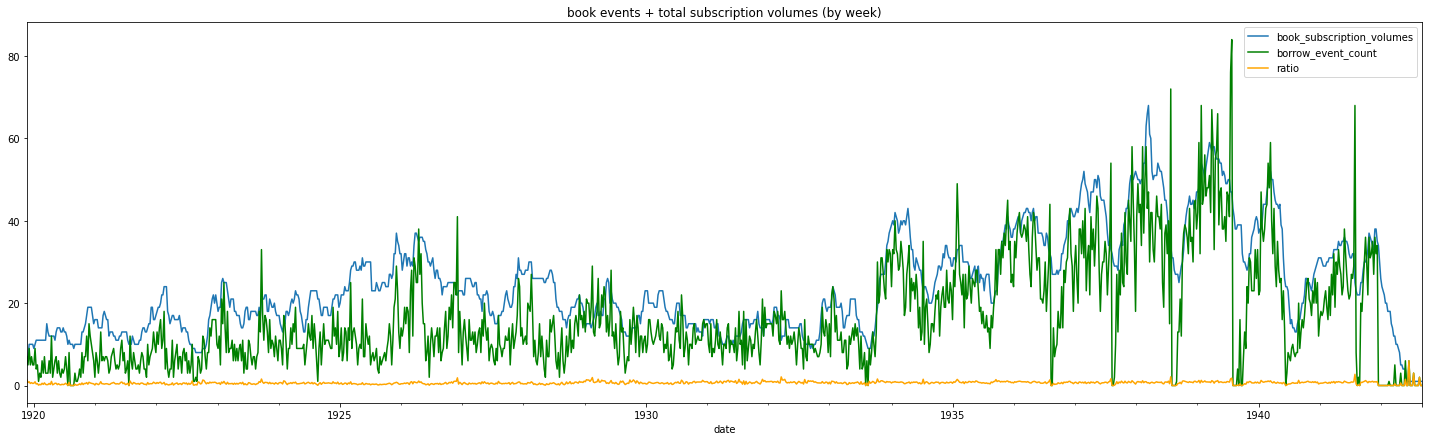

In [26]:
import matplotlib.pyplot as plt


# get current axis so we can plot two series on the same axis
ax = plt.gca()

borrowing_weekly.plot(kind='line',x='date',y='book_subscription_volumes',ax=ax, figsize=(25,7), title='book events + total subscription volumes (by week)')
borrowing_weekly.plot(kind='line',x='date',y='borrow_event_count', color='green', ax=ax)
borrowing_weekly.plot(kind='line',x='date',y='ratio', color='orange', ax=ax)


plt.show()


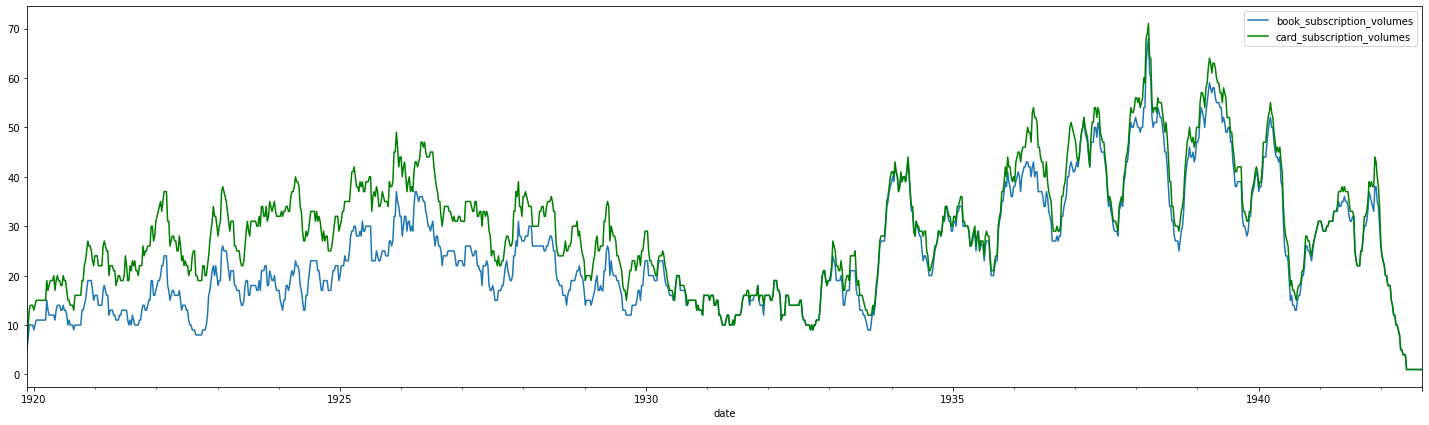

In [27]:
# how different are card volumes and book subscription volumes?

ax = plt.gca()
borrowing_weekly.plot(kind='line',x='date',y='book_subscription_volumes',ax=ax, figsize=(25,7))
borrowing_weekly.plot(kind='line',x='date',y='card_subscription_volumes', color='green', ax=ax)

plt.show()

In [28]:
# let's try aggregating by month
# borrowing_monthly = borrowing_df.groupby([pd.Grouper(key='date', freq='MS')]).agg({'book_subscription_volumes':'mean','borrow_event_count': 'sum'})
# borrowing_monthly = borrowing_monthly.reset_index()
# borrowing_monthly

# borrowing_monthly = borrowing_daily.groupby([pd.Grouper(key='date', freq='MS')]).agg({'book_subscription_volumes':'mean','borrow_event_count': 'sum'})

borrowing_monthly = borrowing_daily.groupby([pd.Grouper(key='date', freq='MS')]).agg({'book_subscription_volumes':'max','borrow_event_count': 'sum'})
borrowing_monthly = borrowing_monthly.reset_index()
borrowing_monthly


,date,book_subscription_volumes,borrow_event_count
0,1919-11-01,7.0,12
1,1919-12-01,10.0,30
2,1920-01-01,11.0,20
3,1920-02-01,11.0,14
4,1920-03-01,15.0,18
...,...,...,...
270,1942-05-01,5.0,6
271,1942-06-01,1.0,6
272,1942-07-01,1.0,3
273,1942-08-01,1.0,2


In [29]:
borrowing_monthly.borrow_event_count.describe()

count    275.000000
mean      71.360000
std       50.290302
min        0.000000
25%       38.500000
50%       53.000000
75%       99.500000
max      251.000000
Name: borrow_event_count, dtype: float64

In [30]:
borrowing_monthly['ratio'] = borrowing_monthly.apply(lambda row: row.borrow_event_count / row.book_subscription_volumes, axis=1)
borrowing_monthly.ratio.describe()

count    275.000000
mean       2.600836
std        0.985389
min        0.000000
25%        1.935417
50%        2.625000
75%        3.264231
max        6.000000
Name: ratio, dtype: float64

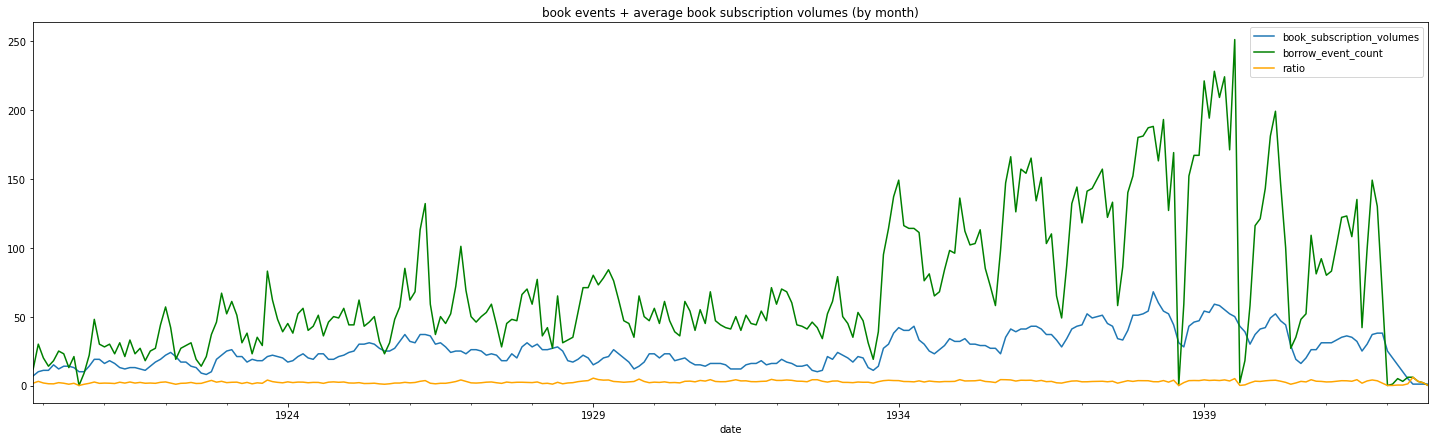

In [31]:
# get current axis so we can plot two series on the same axis
ax = plt.gca()

borrowing_monthly.plot(kind='line',x='date',y='book_subscription_volumes',ax=ax, figsize=(25,7), title='book events + average book subscription volumes (by month)')
borrowing_monthly.plot(kind='line',x='date',y='borrow_event_count', color='green', ax=ax)
borrowing_monthly.plot(kind='line',x='date',y='ratio', color='orange', ax=ax)


plt.show()

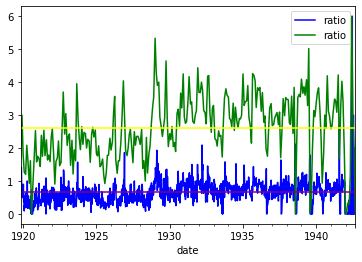

In [32]:
# if we plot just the ratio, how stable is it?
ax = plt.gca()

borrowing_weekly.plot(kind='line',x='date',y='ratio', color='blue', ax=ax)
borrowing_monthly.plot(kind='line',x='date',y='ratio', color='green', ax=ax)

# monthly ratio average
#plt.axhline(y=2.858, color='yellow', linestyle='-')  # 2.8 is ratio when we use average subscription
plt.axhline(y=2.6, color='yellow', linestyle='-')  # 2.6 is ratio when we use max # subscriptions


# weekly ratio average
plt.axhline(y=0.663, color='purple', linestyle='-')  # weekly ratio doesn't change noticeably when we switch from mean to max

plt.show()

In [33]:
# ok, now apply our ratio to the non-book subscription volumes
borrowing_weekly['non_book_subs_vols'] = borrowing_weekly.apply(lambda row: row.subscription_volumes - row.book_subscription_volumes, axis=1)
borrowing_weekly.head()

,date,book_subscription_volumes,borrow_event_count,card_subscription_volumes,subscription_volumes,ratio,non_book_subs_vols
0,1919-11-23,5.0,7,6.0,14.0,1.400000,9.0
1,1919-11-30,7.0,5,9.0,27.0,0.714286,20.0
2,1919-12-07,10.0,9,13.0,41.0,0.900000,31.0
3,1919-12-14,10.0,5,14.0,47.0,0.500000,37.0
4,1919-12-21,10.0,7,14.0,48.0,0.700000,38.0


In [34]:
borrow_events_per_subsvol = borrowing_weekly.ratio.mean()
borrow_events_per_subsvol

0.6428904216675599

In [35]:
# find an example
borrowing_weekly[borrowing_weekly.ratio >= 0.6][borrowing_weekly.ratio <= 0.65]


<ipython-input-35-2245af11e64b>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  borrowing_weekly[borrowing_weekly.ratio >= 0.6][borrowing_weekly.ratio <= 0.65]


,date,book_subscription_volumes,borrow_event_count,card_subscription_volumes,subscription_volumes,ratio,non_book_subs_vols
15,1920-03-07,11.0,7,15.0,82.0,0.636364,71.0
47,1920-10-17,13.0,8,19.0,80.0,0.615385,67.0
54,1920-12-05,19.0,12,26.0,126.0,0.631579,107.0
73,1921-04-17,13.0,8,22.0,147.0,0.615385,134.0
83,1921-06-26,13.0,8,20.0,133.0,0.615385,120.0
...,...,...,...,...,...,...,...
1082,1940-08-18,13.0,8,15.0,34.0,0.615385,21.0
1105,1941-01-26,29.0,18,29.0,83.0,0.620690,54.0
1108,1941-02-16,30.0,19,30.0,84.0,0.633333,54.0
1121,1941-05-18,35.0,22,38.0,99.0,0.628571,64.0


In [36]:
borrowing_weekly['estimated_borrow_events'] = borrowing_weekly.non_book_subs_vols.apply(lambda x: x * borrow_events_per_subsvol)
borrowing_weekly

,date,book_subscription_volumes,borrow_event_count,card_subscription_volumes,subscription_volumes,ratio,non_book_subs_vols,estimated_borrow_events
0,1919-11-23,5.0,7,6.0,14.0,1.400000,9.0,5.786014
1,1919-11-30,7.0,5,9.0,27.0,0.714286,20.0,12.857808
2,1919-12-07,10.0,9,13.0,41.0,0.900000,31.0,19.929603
3,1919-12-14,10.0,5,14.0,47.0,0.500000,37.0,23.786946
4,1919-12-21,10.0,7,14.0,48.0,0.700000,38.0,24.429836
...,...,...,...,...,...,...,...,...
1185,1942-08-09,1.0,0,1.0,1.0,0.000000,0.0,0.000000
1186,1942-08-16,1.0,0,1.0,1.0,0.000000,0.0,0.000000
1187,1942-08-23,1.0,2,1.0,1.0,2.000000,0.0,0.000000
1188,1942-08-30,1.0,0,1.0,1.0,0.000000,0.0,0.000000


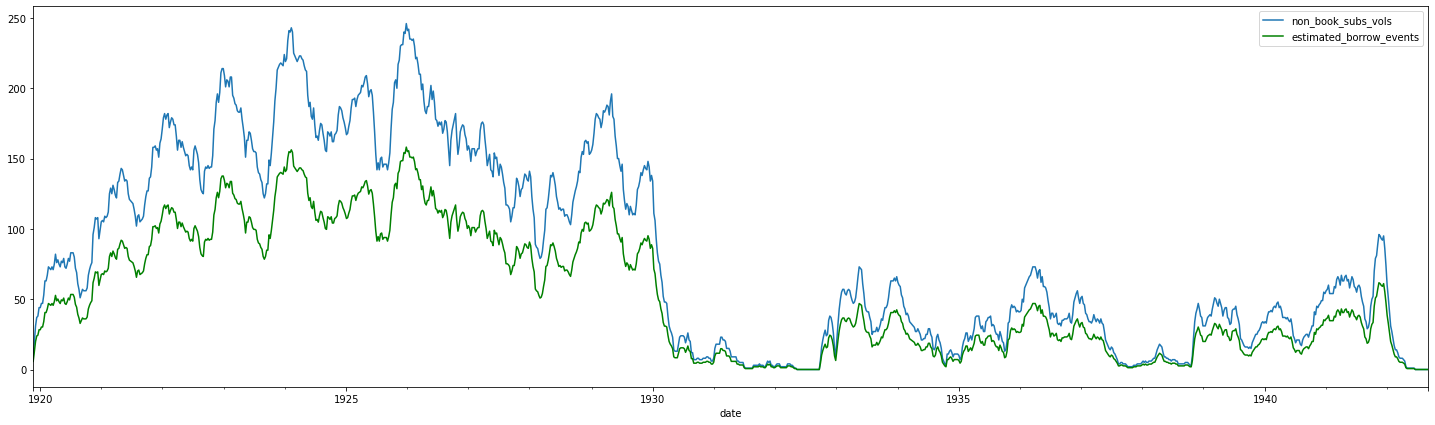

In [37]:
# plot with our estimates
ax = plt.gca()

borrowing_weekly.plot(kind='line',x='date',y='non_book_subs_vols',ax=ax, figsize=(25,7))
borrowing_weekly.plot(kind='line',x='date',y='estimated_borrow_events', color='green', ax=ax)


plt.show()

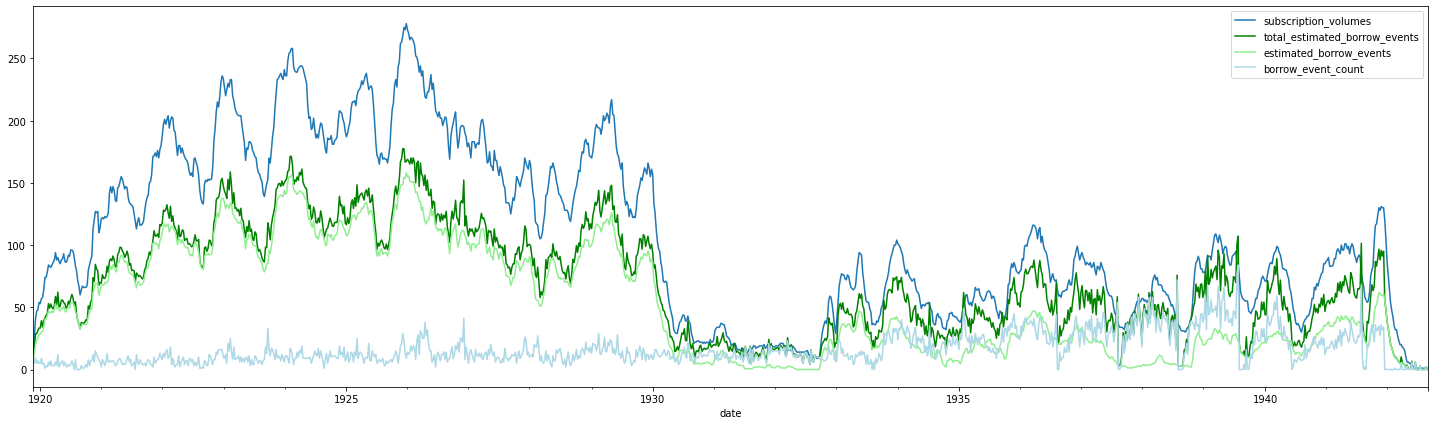

In [38]:
# now combine and plot the total

ax = plt.gca()
# tally up our estimate with the actual event count
borrowing_weekly['total_estimated_borrow_events'] = borrowing_weekly.apply(lambda row: row.estimated_borrow_events + row.borrow_event_count, axis=1)


borrowing_weekly.plot(kind='line',x='date',y='subscription_volumes',ax=ax, figsize=(25,7))
borrowing_weekly.plot(kind='line',x='date',y='total_estimated_borrow_events', color='green', ax=ax)
borrowing_weekly.plot(kind='line',x='date',y='estimated_borrow_events', color='lightgreen', ax=ax)
borrowing_weekly.plot(kind='line',x='date',y='borrow_event_count', color='lightblue', ax=ax)


plt.show()

In [87]:
# replot with altair
import altair as alt

# flatten so we can plot with altair and display with a color-coded legend

alt_subs_vols = borrowing_weekly.rename(columns={"subscription_volumes": "total"})[["date", "total"]]
alt_subs_vols["type"] = "Subscription volumes"

alt_borrow_count = borrowing_weekly.rename(columns={"borrow_event_count": "total"})[["date", "total"]]
alt_borrow_count["type"] = "Borrow event count"

alt_est_borrow_count = borrowing_weekly.rename(columns={"estimated_borrow_events": "total"})[["date", "total"]]
alt_est_borrow_count["type"] = "Estimated borrow events"

alt_totalest_borrow_count = borrowing_weekly.rename(columns={"total_estimated_borrow_events": "total"})[["date", "total"]]
alt_totalest_borrow_count["type"] = "Total estimated borrow events"

alt_borrowing_weekly = pd.concat([alt_subs_vols, alt_borrow_count, alt_est_borrow_count, alt_totalest_borrow_count])

alt_borrowing_weekly


,date,total,type
0,1919-11-23,14.0,Subscription volumes
1,1919-11-30,27.0,Subscription volumes
2,1919-12-07,41.0,Subscription volumes
3,1919-12-14,47.0,Subscription volumes
4,1919-12-21,48.0,Subscription volumes
...,...,...,...
1185,1942-08-09,0.0,Total estimated borrow events
1186,1942-08-16,0.0,Total estimated borrow events
1187,1942-08-23,2.0,Total estimated borrow events
1188,1942-08-30,0.0,Total estimated borrow events


In [96]:
chart = alt.Chart(alt_borrowing_weekly).encode(
    alt.X('date:T', axis=alt.Axis(title='Duration of the Lending Library')),
).properties(
    width=1200,
    # height=chart_height
)

estimated_borrowing = chart.mark_line(strokeWidth=1).encode(
    alt.Y("total", axis=alt.Axis(title='Number of volumes')),
    color=alt.Color("type", title="", scale=alt.Scale(domain=["Subscription volumes", "Borrow event count", "Estimated borrow events", "Total estimated borrow events"],
                                                      range=["#5276A7", "green", "lightgreen", "lightblue"]))
)
estimated_borrowing


alt.Chart(...)

In [97]:
# figure 8
estimated_borrowing.save("fig8-estimated_borrowing.json")

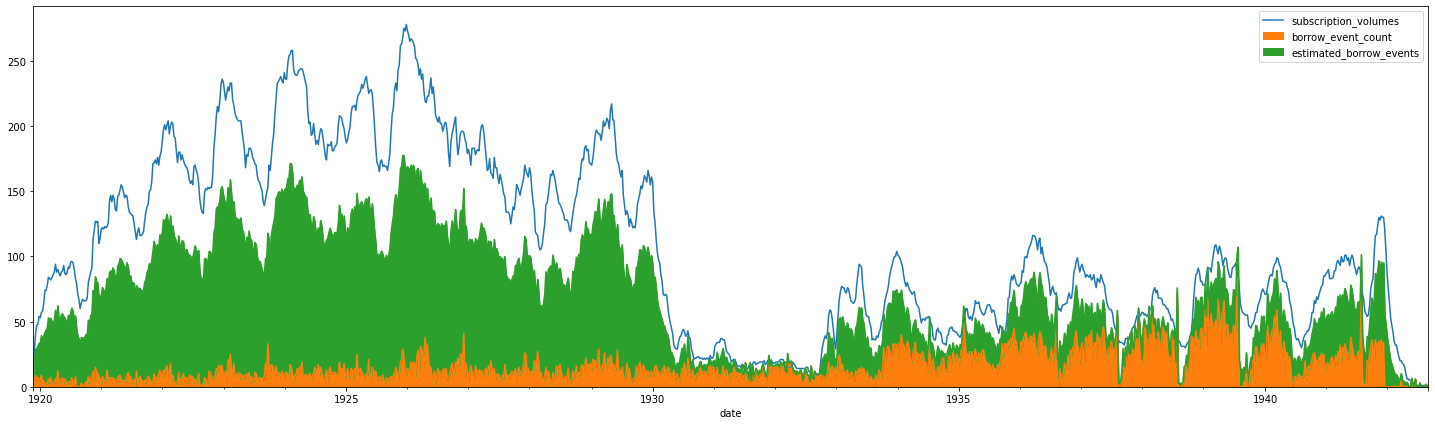

In [40]:
ax = plt.gca()
# total subscriptoin volumes
borrowing_weekly.plot(kind='line',x='date',y='subscription_volumes',ax=ax, figsize=(25,7))
# stacked area chart of actual borrows and estimated missing 
borrowing_weekly[['date', 'borrow_event_count', 'estimated_borrow_events']].plot.area(x='date', stacked=True, ax=ax)
# line plot the total over the stack (not really helpful)
# borrowing_weekly.plot(kind='line',x='date',y='total_estimated_borrow_events', color='yellow', ax=ax)




In [41]:
# how about some numbers?

# total number of estimated missing borrow events based on known subscriptions
est_total_missing_borrows = borrowing_weekly.estimated_borrow_events.sum()
est_total_missing_borrows

63330.49254804966

In [42]:
# how many borrow events did we use to generate our estimate? 
total_borrows_used_to_estimate =  borrows_within_subscriptions.shape[0]
total_borrows_used_to_estimate

17292

In [43]:
all_borrows = events_df[events_df.event_type == 'Borrow']
all_borrows

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,...,item_year,item_notes,source_type,source_citation,source_manifest,source_image,first_member_uri,second_member_uri,member_id,item_id
2,Borrow,1922,1922-08-23,https://shakespeareandco.princeton.edu/members...,Mr. Rhys,"Rhys, Mr.",NaN,NaN,NaN,NaN,...,1902.0,NaN,Lending Library Card,"Sylvia Beach, Rhys Lending Library Card, Box 4...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/67...,https://shakespeareandco.princeton.edu/members...,None,rhys,conrad-typhoon
8,Borrow,1923,1923-11-07,https://shakespeareandco.princeton.edu/members...,Eyre de Lanux / Mrs. Pierre de Lanux,"de Lanux, Eyre",NaN,NaN,NaN,NaN,...,1919.0,NaN,Lending Library Card,"Sylvia Beach, Eyre de Lanux Lending Library Ca...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/c5...,https://shakespeareandco.princeton.edu/members...,None,lanux-eyre-de,woolf-night-day
12,Borrow,1924,1924-10-22,https://shakespeareandco.princeton.edu/members...,Simone Téry,"Téry, Simone",NaN,NaN,NaN,NaN,...,NaN,Unidentified. By or about Joyce.,Lending Library Card,"Sylvia Beach, Mlle Simone Tery Lending Library...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/c2...,https://shakespeareandco.princeton.edu/members...,None,tery,james-joyce
13,Borrow,1924,1924-10-22,https://shakespeareandco.princeton.edu/members...,Simone Téry,"Téry, Simone",NaN,NaN,NaN,NaN,...,1922.0,NaN,Lending Library Card,"Sylvia Beach, Mlle Simone Tery Lending Library...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/c2...,https://shakespeareandco.princeton.edu/members...,None,tery,freeman-portrait-george-moore
22,Borrow,1926,1926-01-14,https://shakespeareandco.princeton.edu/members...,Ada (Hitchcock) MacLeish;Archibald MacLeish,"MacLeish, Ada;MacLeish, Archibald",NaN,NaN,NaN,NaN,...,1924.0,NaN,Lending Library Card,"Sylvia Beach, Ada and Archibald MacLeish Lendi...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/22...,https://shakespeareandco.princeton.edu/members...,https://shakespeareandco.princeton.edu/members...,macleish-ada,stern-tents-israel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35457,Borrow,NaN,NaN,https://shakespeareandco.princeton.edu/members...,Bernard Hommel,"Hommel, Bernard",NaN,NaN,NaN,NaN,...,NaN,NaN,Lending Library Card,"Sylvia Beach, Bernard Hommel Lending Library C...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/e4...,https://shakespeareandco.princeton.edu/members...,None,hommel-bernard,heine-poems
35460,Borrow,NaN,NaN,https://shakespeareandco.princeton.edu/members...,Bernard Hommel,"Hommel, Bernard",NaN,NaN,NaN,NaN,...,1934.0,NaN,Lending Library Card,"Sylvia Beach, Bernard Hommel Lending Library C...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/e4...,https://shakespeareandco.princeton.edu/members...,None,hommel-bernard,cowley-exiles-return-narrative
35463,Borrow,NaN,NaN,https://shakespeareandco.princeton.edu/members...,Bernard Hommel,"Hommel, Bernard",NaN,NaN,NaN,NaN,...,1931.0,NaN,Lending Library Card,"Sylvia Beach, Bernard Hommel Lending Library C...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/e4...,https://shakespeareandco.princeton.edu/members...,None,hommel-bernard,wilson-axels-castle-study
35464,Borrow,NaN,NaN,https://shakespeareandco.princeton.edu/members...,Bernard Hommel,"Hommel, Bernard",NaN,NaN,NaN,NaN,...,NaN,Unidentified. James Thomson's *The City of Dre...,Lending Library Card,"Sylvia Beach, Bernard Hommel Lending Library C...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princet

## borrow estimate for specific periods


### feb 28 1931 — 75 books out

noted on the handwritten tally of the library books

In [44]:
borrowing_weekly[borrowing_weekly.date >= pd.to_datetime(date(1931, 2, 1))][borrowing_weekly.date <= pd.to_datetime(date(1931, 2, 28))]


<ipython-input-44-8336feadd4ff>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  borrowing_weekly[borrowing_weekly.date >= pd.to_datetime(date(1931, 2, 1))][borrowing_weekly.date <= pd.to_datetime(date(1931, 2, 28))]


,date,book_subscription_volumes,borrow_event_count,card_subscription_volumes,subscription_volumes,ratio,non_book_subs_vols,estimated_borrow_events,total_estimated_borrow_events
584,1931-02-01,16.0,7,16.0,34.0,0.437500,18.0,11.572028,18.572028
585,1931-02-08,16.0,9,16.0,34.0,0.562500,18.0,11.572028,20.572028
586,1931-02-15,14.0,8,14.0,37.0,0.571429,23.0,14.786480,22.786480
587,1931-02-22,14.0,11,14.0,37.0,0.785714,23.0,14.786480,25.786480


oh, but her tally is books out, not book events; can we compare that?

In [45]:
subscriptions_df.head()

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,...,source_citation,source_manifest,source_image,first_member_uri,second_member_uri,member_id,item_id,start_datetime,end_datetime,documented_borrows
671,Subscription,1919-11-17,1919-12-17,https://shakespeareandco.princeton.edu/members...,Claude Cahun / Mlle Lucie Schwob,"Cahun, Claude",4.0,NaN,1 month,30.0,...,"Sylvia Beach, Lucie Schwob Lending Library Car...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/3a...,https://shakespeareandco.princeton.edu/members...,None,cahun,None,1919-11-17,1919-12-17,3
29915,Subscription,1919-11-17,1920-11-17,https://shakespeareandco.princeton.edu/members...,Marcelle Flot,"Flot, Marcelle",28.0,NaN,1 year,366.0,...,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,https://shakespeareandco.princeton.edu/members...,None,flot-marcelle,None,1919-11-17,1920-11-17,0
29914,Subscription,1919-11-17,1920-02-17,https://shakespeareandco.princeton.edu/members...,Mrs. Worthing,"Worthing, Mrs.",12.0,NaN,3 months,92.0,...,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,https://shakespeareandco.princeton.edu/members...,None,worthing,None,1919-11-17,1920-02-17,0
29916,Subscription,1919-11-18,1920-05-18,https://shakespeareandco.princeton.edu/members...,Anne Evans,"Evans, Anne",35.0,14.0,6 months,182.0,...,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,https://shakespeareandco.princeton.edu/members...,None,evans-anne,None,1919-11-18,1920-05-18,0
672,Subscription,1919-11-18,1919-12-18,https://shakespeareandco.princeton.edu/members...,Henri Regnier,"Regnier, Henri",4.0,5.6,1 month,30.0,...,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",;https://figgy.princeton.edu/concern/scanned_r...,;https://iiif.princeton.edu/loris/figgy_prod/c...,https://shakespeareandco.princeton.edu/members...,None,regnier,None,1919-11-18,1919-12-18,1


In [46]:
tally_date = pd.to_datetime(date(1931, 2, 28))

# how many subscriptions are active over this date?

tally_subs = subscriptions_df[(subscriptions_df.start_datetime <= tally_date) & (subscriptions_df.end_datetime >= tally_date)]
tally_subs.head()

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,...,source_citation,source_manifest,source_image,first_member_uri,second_member_uri,member_id,item_id,start_datetime,end_datetime,documented_borrows
11153,Renewal,1930-03-05,1931-03-05,https://shakespeareandco.princeton.edu/members...,Helene Brémond,"Brémond, Helene",240.0,NaN,1 year,365.0,...,"Sylvia Beach, Helene Bremond Lending Library C...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/cb...,https://shakespeareandco.princeton.edu/members...,None,bremond-helene,None,1930-03-05,1931-03-05,29
11234,Renewal,1930-04-06,1931-04-06,https://shakespeareandco.princeton.edu/members...,Renée Antoine-May,"Antoine-May, Renée",240.0,NaN,1 year,365.0,...,"Sylvia Beach, Renée Antoine-May Lending Librar...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/7c...,https://shakespeareandco.princeton.edu/members...,None,antoine-may,None,1930-04-06,1931-04-06,30
11261,Renewal,1930-04-20,1931-04-20,https://shakespeareandco.princeton.edu/members...,Mrs. Bernheim,"Bernheim, Mrs.",300.0,NaN,1 year,365.0,...,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",;https://figgy.princeton.edu/concern/scanned_r...,;https://iiif.princeton.edu/loris/figgy_prod/c...,https://shakespeareandco.princeton.edu/members...,None,bernheim,None,1930-04-20,1931-04-20,7
11287,Renewal,1930-05-08,1931-05-08,https://shakespeareandco.princeton.edu/members...,France Emma Raphaël,"Raphaël, France Emma",240.0,NaN,1 year,365.0,...,"Sylvia Beach, France Emma Raphaël Lending Libr...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/0f...,https://shakespeareandco.princeton.edu/members...,None,raphael-france,None,1930-05-08,1931-05-08,55
11331,Renewal,1930-06-05,1931-06-05,https://shakespeareandco.princeton.edu/members...,Darsie Japp,"Japp, Darsie",240.0,NaN,1 year,365.0,...,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,https://shakespeareandco.princeton.edu/members...,None,japp-darsie,None,1930-06-05,1931-06-05,0


In [47]:
tally_subs.shape[0]

31

In [48]:
# for how many members? 
len(tally_subs.member_id.unique())

30

In [49]:
# how many subscription volumes?

tally_subs.subscription_volumes.describe()

count    31.000000
mean      1.161290
std       0.454369
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       3.000000
Name: subscription_volumes, dtype: float64

In [50]:
tally_subs.subscription_volumes.sum()

36.0

In [51]:
# how many subscriptions with volume > 1 ?
tally_subs.subscription_volumes.value_counts()

1.0    27
2.0     3
3.0     1
Name: subscription_volumes, dtype: int64

In [52]:
# which members had subscriptions with volume > 1 ?
tally_subs[tally_subs.subscription_volumes > 1][['event_type', 'start_date', 'end_date', 'member_names', 'subscription_volumes']]

,event_type,start_date,end_date,member_names,subscription_volumes
11369,Renewal,1930-06-23,1931-06-23,Mr. O'Conor,2.0
11670,Renewal,1930-11-01,1931-11-01,Fernand Colens,2.0
11753,Renewal,1930-12-09,1931-03-09,Dolly Wilde / Miss Dorothy Wilde,3.0
33610,Renewal,1931-02-14,1931-05-14,Tolstoy,2.0


In [53]:
# how many borrows do we have for that date?


tally_borrows = borrow_events_df[(borrow_events_df.start_datetime <= tally_date) & (borrow_events_df.end_datetime >= tally_date)]
tally_borrows.head()

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,...,source_citation,source_manifest,source_image,first_member_uri,second_member_uri,member_id,item_id,start_datetime,end_datetime,within_subscription
2652,Borrow,1922-12-30,1932-05-02,https://shakespeareandco.princeton.edu/members...,Jacques Porel,"Porel, Jacques",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Jacques Porel Lending Library Ca...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/7f...,https://shakespeareandco.princeton.edu/members...,None,porel,hardy-trumpet-major,1922-12-30,1932-05-02,True
10818,Borrow,1929-10-26,1931-11-14,https://shakespeareandco.princeton.edu/members...,Anatole Rivoallan,"Rivoallan, Anatole",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Rivoallan Lending Library Card, ...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif-cloud.princeton.edu/iiif/2/e0%2F1...,https://shakespeareandco.princeton.edu/members...,None,rivoallan-anatole,deirdre,1929-10-26,1931-11-14,True
10872,Borrow,1929-11-14,1931-12-21,https://shakespeareandco.princeton.edu/members...,Anatole Rivoallan,"Rivoallan, Anatole",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Rivoallan Lending Library Card, ...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif-cloud.princeton.edu/iiif/2/e0%2F1...,https://shakespeareandco.princeton.edu/members...,None,rivoallan-anatole,huxley-crome-yellow,1929-11-14,1931-12-21,True
10990,Borrow,1929-12-21,1931-11-19,https://shakespeareandco.princeton.edu/members...,Anatole Rivoallan,"Rivoallan, Anatole",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Rivoallan Lending Library Card, ...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif-cloud.princeton.edu/iiif/2/e0%2F1...,https://shakespeareandco.princeton.edu/members...,None,rivoallan-anatole,a-e-imaginations-reveries,1929-12-21,1931-11-19,True
11782,Borrow,1930-12-19,1931-03-27,https://shakespeareandco.princeton.edu/members...,Dolly Wilde / Miss Dorothy Wilde,"Wilde, Dolly",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Dorothy Wilde Lending Library Ca...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif-cloud.princeton.edu/iiif/2/1d%2F3...,https://shakespeareandco.princeton.edu/members...,None,wilde-dorothy,arnold-happened-andals,1930-12-19,1931-03-27,True


In [54]:
# how many books out?
tally_borrows.shape[0]

32

In [55]:
# how many members?
len(tally_borrows.member_id.unique())

18

In [56]:
75/36

2.0833333333333335

## % borrowing from early period?

In [57]:
# first logbook gap is January 01 1928

first_gap_start = pd.to_datetime(date(1928, 1, 1))

pre_first_gap_borrowing = borrowing_weekly[borrowing_weekly.date < first_gap_start]
pre_first_gap_borrowing

,date,book_subscription_volumes,borrow_event_count,card_subscription_volumes,subscription_volumes,ratio,non_book_subs_vols,estimated_borrow_events,total_estimated_borrow_events
0,1919-11-23,5.0,7,6.0,14.0,1.400000,9.0,5.786014,12.786014
1,1919-11-30,7.0,5,9.0,27.0,0.714286,20.0,12.857808,17.857808
2,1919-12-07,10.0,9,13.0,41.0,0.900000,31.0,19.929603,28.929603
3,1919-12-14,10.0,5,14.0,47.0,0.500000,37.0,23.786946,28.786946
4,1919-12-21,10.0,7,14.0,48.0,0.700000,38.0,24.429836,31.429836
...,...,...,...,...,...,...,...,...,...
418,1927-11-27,26.0,17,36.0,160.0,0.653846,134.0,86.147317,103.147317
419,1927-12-04,31.0,26,39.0,170.0,0.838710,139.0,89.361769,115.361769
420,1927-12-11,28.0,24,34.0,166.0,0.857143,138.0,88.718878,112.718878
421,1927-12-18,28.0,12,34.0,163.0,0.428571,135.0,86.790207,98.790207


In [58]:
# what is the estimated borrowing vs actual?

pregap_est_total = pre_first_gap_borrowing.total_estimated_borrow_events.sum()

pregap_est_total

46024.66714941317

In [59]:
pregap_known_total = pre_first_gap_borrowing.borrow_event_count.sum()

pregap_known_total

4159

In [60]:
pregap_known_total / pregap_est_total

0.09036458615764326

In [61]:
pregap_known_total / pregap_est_total * 100

9.036458615764326

## % borrowing in the 1930s between gaps?

In [62]:
# period in the 1930s between gaps
# February 17 1931 to September 25 1932 (586 days)
#	January 01 1937 to February 16 1938 (411 days)
#	May 06 1938 to October 20 1938 (167 days)
#	August 29 1939 to September 12 1939 (14 days)

mid_gap_start = pd.to_datetime(date(1932, 9, 25))
mid_gap_end =  pd.to_datetime(date(1937, 1, 1))

mid_gap_borrowing = borrowing_weekly[borrowing_weekly.date > mid_gap_start][borrowing_weekly.date < mid_gap_end]
mid_gap_borrowing

<ipython-input-62-56aac9c01fca>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mid_gap_borrowing = borrowing_weekly[borrowing_weekly.date > mid_gap_start][borrowing_weekly.date < mid_gap_end]


,date,book_subscription_volumes,borrow_event_count,card_subscription_volumes,subscription_volumes,ratio,non_book_subs_vols,estimated_borrow_events,total_estimated_borrow_events
671,1932-10-02,10.0,8,10.0,17.0,0.800000,7.0,4.500233,12.500233
672,1932-10-09,10.0,9,10.0,26.0,0.900000,16.0,10.286247,19.286247
673,1932-10-16,11.0,8,11.0,32.0,0.727273,21.0,13.500699,21.500699
674,1932-10-23,11.0,7,11.0,36.0,0.636364,25.0,16.072261,23.072261
675,1932-10-30,11.0,7,11.0,39.0,0.636364,28.0,18.000932,25.000932
...,...,...,...,...,...,...,...,...,...
888,1936-11-29,40.0,39,47.0,91.0,0.975000,51.0,32.787412,71.787412
889,1936-12-06,42.0,43,50.0,96.0,1.023810,54.0,34.716083,77.716083
890,1936-12-13,43.0,32,51.0,99.0,0.744186,56.0,36.001864,68.001864
891,1936-12-20,42.0,29,50.0,93.0,0.690476,51.0,32.787412,61.787412


In [63]:
# what is the estimated borrowing vs actual?

mid_gap_borrowing_est_total = mid_gap_borrowing.total_estimated_borrow_events.sum()

mid_gap_borrowing_est_total

10111.2744170707

In [64]:
# borrows with any date, to improve our reporting by period

all_borrows = events_df[events_df.event_type == 'Borrow']
all_borrows.head()

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,...,item_year,item_notes,source_type,source_citation,source_manifest,source_image,first_member_uri,second_member_uri,member_id,item_id
2,Borrow,1922,1922-08-23,https://shakespeareandco.princeton.edu/members...,Mr. Rhys,"Rhys, Mr.",NaN,NaN,NaN,NaN,...,1902.0,NaN,Lending Library Card,"Sylvia Beach, Rhys Lending Library Card, Box 4...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/67...,https://shakespeareandco.princeton.edu/members...,None,rhys,conrad-typhoon
8,Borrow,1923,1923-11-07,https://shakespeareandco.princeton.edu/members...,Eyre de Lanux / Mrs. Pierre de Lanux,"de Lanux, Eyre",NaN,NaN,NaN,NaN,...,1919.0,NaN,Lending Library Card,"Sylvia Beach, Eyre de Lanux Lending Library Ca...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/c5...,https://shakespeareandco.princeton.edu/members...,None,lanux-eyre-de,woolf-night-day
12,Borrow,1924,1924-10-22,https://shakespeareandco.princeton.edu/members...,Simone Téry,"Téry, Simone",NaN,NaN,NaN,NaN,...,NaN,Unidentified. By or about Joyce.,Lending Library Card,"Sylvia Beach, Mlle Simone Tery Lending Library...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/c2...,https://shakespeareandco.princeton.edu/members...,None,tery,james-joyce
13,Borrow,1924,1924-10-22,https://shakespeareandco.princeton.edu/members...,Simone Téry,"Téry, Simone",NaN,NaN,NaN,NaN,...,1922.0,NaN,Lending Library Card,"Sylvia Beach, Mlle Simone Tery Lending Library...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/c2...,https://shakespeareandco.princeton.edu/members...,None,tery,freeman-portrait-george-moore
22,Borrow,1926,1926-01-14,https://shakespeareandco.princeton.edu/members...,Ada (Hitchcock) MacLeish;Archibald MacLeish,"MacLeish, Ada;MacLeish, Archibald",NaN,NaN,NaN,NaN,...,1924.0,NaN,Lending Library Card,"Sylvia Beach, Ada and Archibald MacLeish Lendi...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/22...,https://shakespeareandco.princeton.edu/members...,https://shakespeareandco.princeton.edu/members...,macleish-ada,stern-tents-israel


In [65]:
def get_best_date(row):
  # dates are strings; return the longest
  start_date_len = len(row.start_date) if pd.notna(row.start_date) else 0
  end_date_len = len(row.end_date) if pd.notna(row.end_date) else 0

  if start_date_len > end_date_len:
    return row.start_date
  else:
    return row.end_date

# get either start or end date, whichever we find first
all_borrows['date'] = all_borrows.apply(get_best_date, axis=1)
all_borrows[['start_date', 'end_date', 'date']].head()

<ipython-input-65-59833e77538b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_borrows['date'] = all_borrows.apply(get_best_date, axis=1)


,start_date,end_date,date
2,1922,1922-08-23,1922-08-23
8,1923,1923-11-07,1923-11-07
12,1924,1924-10-22,1924-10-22
13,1924,1924-10-22,1924-10-22
22,1926,1926-01-14,1926-01-14


In [66]:
# how many are still null?
all_borrows[all_borrows.date.isna()].shape[0]

6

In [67]:
# convert to datetime for comparison/filtering
all_borrows['dt'] = pd.to_datetime(all_borrows.date, errors='coerce')
all_borrows[['start_date', 'end_date', 'date', 'dt']].head()

<ipython-input-67-6dd26202169d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_borrows['dt'] = pd.to_datetime(all_borrows.date, errors='coerce')


,start_date,end_date,date,dt
2,1922,1922-08-23,1922-08-23,1922-08-23
8,1923,1923-11-07,1923-11-07,1923-11-07
12,1924,1924-10-22,1924-10-22,1924-10-22
13,1924,1924-10-22,1924-10-22,1924-10-22
22,1926,1926-01-14,1926-01-14,1926-01-14


In [68]:
# summarize estimate / actual for a particular time period


def borrowing_estimate_by_date(borrowing_weekly, start_date=None, end_date=None):
  borrowing_chunk = borrowing_weekly.copy()
  period_borrows = all_borrows.copy()
  
  if start_date:
    borrowing_chunk = borrowing_chunk[borrowing_chunk.date > start_date]
    period_borrows = period_borrows[period_borrows.dt > start_date]
  if end_date:
    borrowing_chunk = borrowing_chunk[borrowing_chunk.date < end_date]
    period_borrows = period_borrows[period_borrows.dt < end_date]

  # what is the estimated borrowing vs actual?
  est_total = round(borrowing_chunk.total_estimated_borrow_events.sum())
  known_total = borrowing_chunk.borrow_event_count.sum()  
  total_any_borrows = period_borrows.shape[0]

  percent_total = total_any_borrows / est_total * 100

  print(f"""Estimated borrowing between {start_date or ''} — {end_date or ''}:
  estimated total borrowing events: {est_total}
  known borrowing events (with full dates): {known_total}
  known borrowing events (with any dates): {total_any_borrows}
  surviving percent: {percent_total:.2f}
  """)

In [69]:
# before the first gap
borrowing_estimate_by_date(borrowing_weekly, end_date=first_gap_start)

Estimated borrowing between  — 1928-01-01 00:00:00:
  estimated total borrowing events: 46025
  known borrowing events (with full dates): 4159
  known borrowing events (with any dates): 4459
  surviving percent: 9.69
  


In [70]:
# between logbook gaps in the 1930s

mid_gap_start = pd.to_datetime(date(1932, 9, 25))
mid_gap_end =  pd.to_datetime(date(1937, 1, 1))

borrowing_estimate_by_date(borrowing_weekly, mid_gap_start, mid_gap_end)


Estimated borrowing between 1932-09-25 00:00:00 — 1937-01-01 00:00:00:
  estimated total borrowing events: 10111
  known borrowing events (with full dates): 4810
  known borrowing events (with any dates): 5003
  surviving percent: 49.48
  


In [71]:
# after the last logbook gap
# 	August 29 1939 to September 12 1939 (14 days)

last_gap_end = pd.to_datetime(date(1939, 9, 12))

borrowing_estimate_by_date(borrowing_weekly, last_gap_end)

Estimated borrowing between 1939-09-12 00:00:00 — :
  estimated total borrowing events: 6503
  known borrowing events (with full dates): 2790
  known borrowing events (with any dates): 3436
  surviving percent: 52.84
  


## all borrows, official borrows

In [72]:
all_borrows['year'] = all_borrows.start_date.apply(lambda x: x.split('-')[0] if pd.notna(x) else None)
all_borrows.year.unique()

<ipython-input-72-e360fdbd2149>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_borrows['year'] = all_borrows.start_date.apply(lambda x: x.split('-')[0] if pd.notna(x) else None)


array(['1922', '1923', '1924', '1926', '1929', '1931', '1934', '1936',
       '1937', '1938', '1940', '1942', '1944', '1946', '1948', '1952',
       '1955', '1956', '1960', '1920', '1921', '1927', '1928', '1932',
       '1935', None, '1939', '1943', '1945', '1947', '1954', '1961', '',
       '1919', '1925', '1930', '1933', '1941', '1949', '1950', '1951',
       '1953', '1957', '1958', '1962'], dtype=object)

In [73]:
official_borrows = all_borrows[all_borrows.year < "1942"]
official_borrows

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,...,source_citation,source_manifest,source_image,first_member_uri,second_member_uri,member_id,item_id,date,dt,year
2,Borrow,1922,1922-08-23,https://shakespeareandco.princeton.edu/members...,Mr. Rhys,"Rhys, Mr.",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Rhys Lending Library Card, Box 4...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/67...,https://shakespeareandco.princeton.edu/members...,None,rhys,conrad-typhoon,1922-08-23,1922-08-23,1922
8,Borrow,1923,1923-11-07,https://shakespeareandco.princeton.edu/members...,Eyre de Lanux / Mrs. Pierre de Lanux,"de Lanux, Eyre",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Eyre de Lanux Lending Library Ca...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/c5...,https://shakespeareandco.princeton.edu/members...,None,lanux-eyre-de,woolf-night-day,1923-11-07,1923-11-07,1923
12,Borrow,1924,1924-10-22,https://shakespeareandco.princeton.edu/members...,Simone Téry,"Téry, Simone",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Mlle Simone Tery Lending Library...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/c2...,https://shakespeareandco.princeton.edu/members...,None,tery,james-joyce,1924-10-22,1924-10-22,1924
13,Borrow,1924,1924-10-22,https://shakespeareandco.princeton.edu/members...,Simone Téry,"Téry, Simone",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Mlle Simone Tery Lending Library...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/c2...,https://shakespeareandco.princeton.edu/members...,None,tery,freeman-portrait-george-moore,1924-10-22,1924-10-22,1924
22,Borrow,1926,1926-01-14,https://shakespeareandco.princeton.edu/members...,Ada (Hitchcock) MacLeish;Archibald MacLeish,"MacLeish, Ada;MacLeish, Archibald",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Ada and Archibald MacLeish Lendi...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/22...,https://shakespeareandco.princeton.edu/members...,https://shakespeareandco.princeton.edu/members...,macleish-ada,stern-tents-israel,1926-01-14,1926-01-14,1926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29452,Borrow,1941-12-12,NaN,https://shakespeareandco.princeton.edu/members...,Martine Lacorne,"Lacorne, Martine",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Martine Lacorne Lending Library ...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/a5...,https://shakespeareandco.princeton.edu/members...,None,lacorne,bennett-old-wives-tale,1941-12-12,1941-12-12,1941
29458,Borrow,1941-12-12,1942-03-14,https://shakespeareandco.princeton.edu/members...,Madeleine Blaess,"Blaess, Madeleine",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Madeleine Blaess Lending Library...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/c6...,https://shakespeareandco.princeton.edu/members...,None,blaess,de-la-roche-house,1942-03-14,1942-03-14,1941
29459,Borrow,1941-12-12,1942-10-06,https://shakespeareandco.princeton.edu/members...,François Valéry,"Valéry, François",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Monsieur Francois Valery Lending...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/5a...,https://shakespeareandco.princeton.edu/members...,None,valery-francois,views-reviews,1942-10-06,1942-10-06,1941
29460,Borrow,1941-12-12,1942-10-06,https://shakespeareandco.princeton.edu/members...,François Valéry,"Valéry, François",NaN,NaN,NaN,NaN,...,"Sylvia Beach, Monsieur Francois Valery Lending...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/5a...,https://shakespeareandco.princeton.edu/members...,None,valery-francois,thackeray-vanity-fair,1942

## report on excluded events

In [74]:
# how many borrows do we have total? (with/without dates)
# (todo: exclude after last subscription ?)
# members_added = members_added[members_added['date'] < datetime(1942, 1, 1)]

total_borrows = events_df[events_df.event_type == 'Borrow'].shape[0]
total_borrows 

21059

In [75]:
total_official_borrows = official_borrows.shape[0]
total_official_borrows

20597

In [76]:
total_borrows - total_official_borrows

462

In [77]:
total_official_borrows / total_borrows

0.9780616363550027

In [78]:
# what about other book activity?
book_events = events_df[events_df.item_uri.notna()]
total_book_events = book_events.shape[0]
total_book_events

22484

In [79]:
total_official_borrows / total_book_events

0.9160736523750223

In [80]:
total_official_borrows - total_borrows_used_to_estimate  

3305

In [81]:
# estimated total based on subscriptions
est_total = est_total_missing_borrows + total_borrows_used_to_estimate
est_total

80622.49254804966

In [82]:
total_official_borrows / est_total


0.2554746119728875